In [2]:
import pandas as pd
import numpy as np
import folium
from sklearn.cluster import KMeans
from math import *
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from collections import namedtuple

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [52]:
data = pd.read_csv('C:/Users/renz/Downloads/1205_data.csv')
data['LON'] = data['LON'].apply(lambda x : (x - 360) if x>0 else x )

# DBSCAN

In [9]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

In [15]:
data['MMSI2'].unique()

array(['211311970_1', '211311970_2', '211311970_3', '211311970_4',
       '211311970_5', '211311970_6', '211311970_7', '211311970_8',
       '211311970_9'], dtype=object)

In [29]:
X = StandardScaler().fit_transform(data[data['MMSI2']=='211311970_2'][['LAT', 'LON']])

In [30]:
db = DBSCAN(eps=0.5, min_samples=1).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

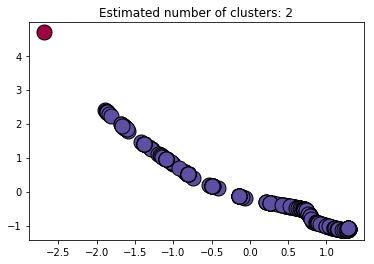

In [33]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=15)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# CLUSTER

# Visual

In [42]:
data1 = data[data['MMSI2']=='211311970_2'].reset_index(drop=True)
m = folium.Map(location=[data1.loc[0,'LAT'], data1.loc[0,'LON']], zoom_start=1, tiles='Stamen Terrain')
for i in range(data1.shape[0]):
    folium.CircleMarker(location=[data1.loc[i,'LAT'], data1.loc[i,'LON']], color = 'red', radius = 1).add_to(m)
m

In [47]:
folium.CircleMarker(location=[8.9, -79.9], color = 'red', radius = 1).add_to(m)

In [48]:
m

In [157]:
# places_on_SAF = pd.read_csv('C:/Users/Lenovo/Downloads/1205_data.csv')
places_on_SAF = data
places_on_SAF['ETA4'] = places_on_SAF.ETA.apply(lambda x: x[:10])
places_on_SAF = pd.concat([places_on_SAF.groupby(['MMSI3','ETA4']).first().reset_index().drop(['ETA4'], axis=1), places_on_SAF.groupby('MMSI3').last().reset_index().drop(['ETA3'], axis=1)]).reset_index(drop=True)
places_on_SAF = pd.DataFrame(places_on_SAF, columns = ["MMSI3","LAT","LON"])
places_on_SAF['LON'] = places_on_SAF['LON'].apply(lambda x : (x - 360) if x>0 else x ) 
places_on_SAF = places_on_SAF[places_on_SAF['MMSI3']=='477157700_6_2'].reset_index(drop=True)

C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  after removing the cwd from sys.path.


In [158]:




a= [] 
for i in range(len(places_on_SAF)) :
     a.append ( tuple( ( places_on_SAF.loc[ i,["LAT","LON" ]])))
places_on_SAF = a
# get the coordinates for these places

lats = [x[0] for x in places_on_SAF]

lons = [x[1] for x in places_on_SAF]

coordinates = zip(lats, lons)
m = folium.Map(location=[36.5,-122], zoom_start=3, tiles='Stamen Terrain')

# Create the map with the appoximate location of San Andreas Fault

SAF = folium.PolyLine(locations = zip(lats, lons),weight=5,color = 'red')
for each in (zip(lats, lons)):  

    folium.CircleMarker(each, radius = 1.5, color = 'blue').add_to(m)
folium.PolyLine(list(zip(lats, lons)), color="blue", weight=2.5).add_to(m) 
# <folium.vector_layers.PolyLine at 0x1f8e49edda0>
def get_bearing(p1, p2):


    

    long_diff = np.radians(p2.lon - p1.lon)

    

    lat1 = np.radians(p1.lat)

    lat2 = np.radians(p2.lat)

    

    x = np.sin(long_diff) * np.cos(lat2)

    y = (np.cos(lat1) * np.sin(lat2) 

        - (np.sin(lat1) * np.cos(lat2) 

        * np.cos(long_diff)))

    bearing = np.degrees(np.arctan2(x, y))

    

    # adjusting for compass bearing

    if bearing < 0:

        return bearing + 360

    return bearing
def get_arrows(locations, color='blue', size=6, n_arrows=len(list(zip(lats,lons)))):

    Point = namedtuple('Point', field_names=['lat', 'lon'])

    

    # creating point from our Point named tuple

    p1 = Point(locations[0][0], locations[0][1])

    p2 = Point(locations[1][0], locations[1][1])

    

    # getting the rotation needed for our marker.  

    # Subtracting 90 to account for the marker's orientation

    # of due East(get_bearing returns North)

    rotation = get_bearing(p1, p2) - 90

    

    # get an evenly space list of lats and lons for our arrows

    # note that I'm discarding the first and last for aesthetics

    # as I'm using markers to denote the start and end

    arrow_lats = np.linspace(p1.lat, p2.lat, n_arrows + 2)[1:n_arrows+1]

    arrow_lons = np.linspace(p1.lon, p2.lon, n_arrows + 2)[1:n_arrows+1]

    

    arrows = []

    

    #creating each "arrow" and appending them to our arrows list

    for points in zip(arrow_lats, arrow_lons):

        arrows.append(folium.RegularPolygonMarker(location=points, 

                      fill_color=color, number_of_sides=3, 

                      radius=size, rotation=rotation).add_to(m))

    return arrows
h = len(places_on_SAF)

 

for i in range(int(h)-1) :

    arrows = get_arrows(list(zip(lats, lons))[i:len(places_on_SAF)], n_arrows=1)

    i + 1

    for arrow in arrows:

        arrow.add_to(m)
m

# error dencity function

In [187]:
error

,Arrive port,MMSI3,Cluster,Regression,Lgbm,Xgboost,Random Forest
0,USOAK,255805930_33_1,2.222200e+04,0.50,1.70,0.98,1.63
1,USOAK,538004202_35_1,2.222200e+04,-0.96,0.40,-0.20,0.33
2,USOAK,564345000_62_1,2.222200e+04,0.60,2.70,2.46,2.46
3,USOAK,636018189_4_1,2.222200e+04,0.90,1.30,1.93,1.35
4,USOAK,636091912_41_5,1.220222e+06,-0.93,-5.60,-5.00,-2.70
5,KRPUS,440024000_46_8,2.222200e+04,50.00,3.60,-0.10,1.21
6,KRPUS,441632000_69_8,2.202220e+05,0.20,3.20,0.09,2.95
7,USLGB,255805930_34_4,1.220000e+13,-2.69,1.00,-0.50,0.54
8,USLGB,372319000_51_3,2.220000e+11,-7.80,-7.19,-5.90,-5.70
9,USLGB,636015660_34_10,1.220000e+13,0.50,-9.86,-1.90,-3.40


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
error = pd.read_csv('D:/SDS_project/data/prediction.csv')


In [9]:
error = error.iloc[:,3:][abs(error.iloc[:,3:]) < 20].dropna(axis=0)

D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'density')

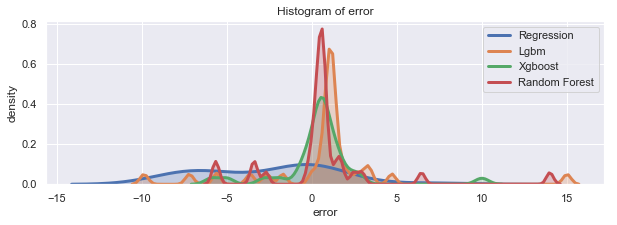

In [20]:
# matplotlib histogram
# plt.hist(error['Regression'], color = 'blue', edgecolor = 'black', bins = int(180/5))

# seaborn histogram
# sns.distplot(error['Regression'], hist=True, kde=False, bins=int(180/5), color = 'blue', hist_kws={'edgecolor':'black'})

# sns.distplot(error['Regression'], hist=True, kde=True, 
#              bins=int(180/5), color = 'darkblue', 
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 4})

sns.set(rc={'figure.figsize':(10,3)})

sns.distplot(error['Regression'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, hist_kws={"range": [-15,20]}, 
                  label = 'Regression')

sns.distplot(error['Lgbm'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, hist_kws={"range": [-15,20]}, 
                  label = 'Lgbm')

sns.distplot(error['Xgboost'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, hist_kws={"range": [-15,20]}, 
                  label = 'Xgboost')

sns.distplot(error['Random Forest'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, hist_kws={"range": [-15,20]}, 
                  label = 'Random Forest')


# Add labels
plt.title('Histogram of error')
plt.xlabel('error')
plt.ylabel('density')